<a href="https://colab.research.google.com/github/RuleOfNight/cifar10/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Lấy data và dataloader

In [ ]:
!git clone https://github.com/cyizhuo/CIFAR-10-dataset.git

fatal: destination path 'CIFAR-10-dataset' already exists and is not an empty directory.


In [ ]:
import os
print(os.path.isdir('/content/CIFAR-10-dataset/train'))

True


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root='/content/CIFAR-10-dataset/train', transform=transform)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

test_data = datasets.ImageFolder(root='/content/CIFAR-10-dataset/test', transform=transform)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
image, label = train_data[0]

In [ ]:
print(image.shape)
print(f"color_channels = {image.shape[0]}, height = {image.shape[1]}, width = {image.shape[2]}")

torch.Size([3, 32, 32])
color_channels = 3, height = 32, width = 32


In [ ]:
len(train_data), len(test_data), len(train_dataloader), len(test_dataloader)

(50000, 10000, 3125, 625)

In [ ]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

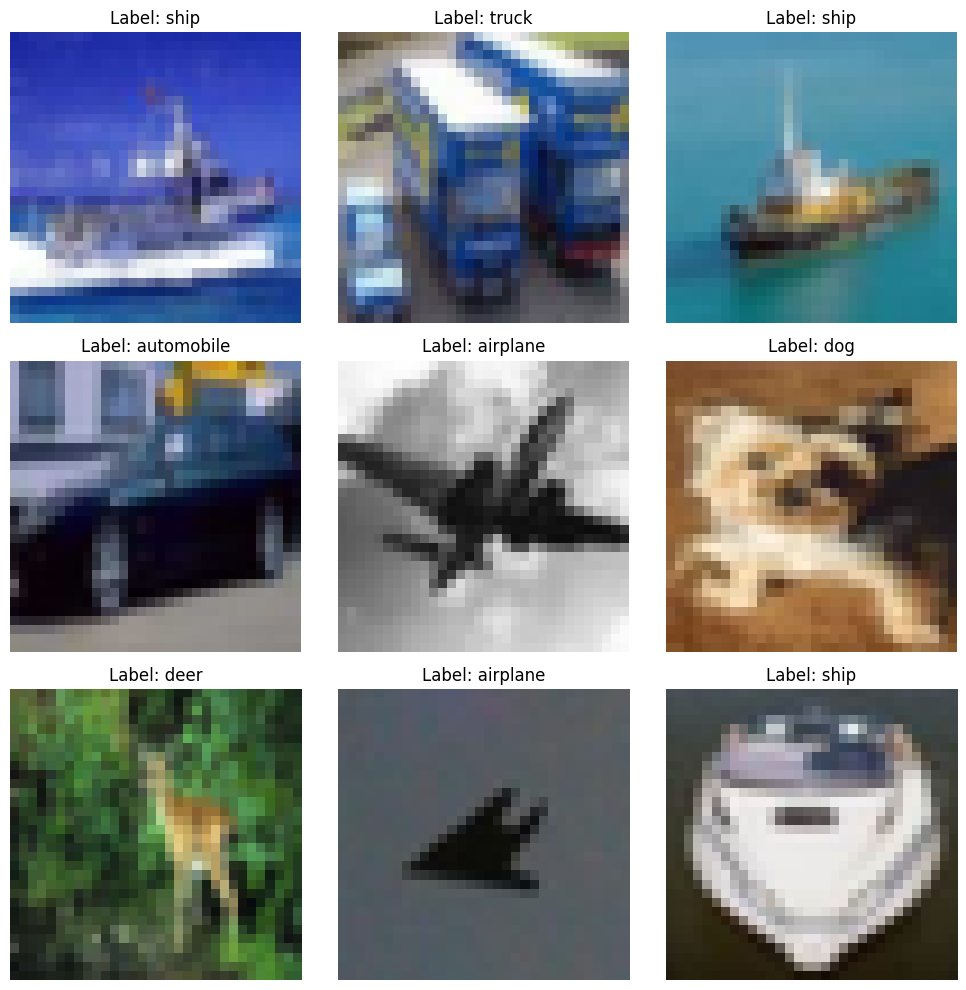

In [ ]:
torch.manual_seed(42)
# Lấy batch từ loader
images, labels = next(iter(train_dataloader))


num_images = 9
images = images[:num_images]
labels = labels[:num_images]


fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = axes.flatten() # Chuyển ma trận axes thành mảng 1 chiều

for i in range(num_images):
    ax = axes[i]
    # Lấy axes hiện tại để vẽ hình ảnh


    image = images[i].numpy().transpose(1, 2, 0) # gpu -> cpu vì plt 0 hỗ trợ

    ax.imshow(image)
    ax.set_title(f"Label: {train_data.classes[labels[i]]}")
    ax.axis(False)

plt.tight_layout()
plt.show()

In [ ]:
print(f"DataLoader: {train_dataloader}")
print(f"Length of training dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")
#

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7eccfaa0c220>
Length of training dataloader: 3125
Length of test dataloader: 625


# Tạo model resnet

**Stateless Function**
Không lưu trạng thái của mô hình như `inplace=True/False` giúp mô hình nhẹ và chạy nhanh hơn.
<br>
Tuy nhiên nó không hỗ trợ nếu muốn tái sử dụng trong nhiều phần của mô hình

In [ ]:
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model resnet18 bình thường sử dụng lớp Convolution

```
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) # conv2 nhận kq từ conv1 nên stride=1, gồm 2 out
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample or(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            if stride != 1 or in_channels != out_channels
            else None
        )

    def forward(self, x):
       # print(f"Input: {x.shape}")
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)
        #print(f"res output: {out.shape}")

        return out
  ```

Model resnet18 sử dụng depthwise

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, stride=1, padding=1) # conv2 nhận kq từ conv1 nên stride=1, gồm 2 out
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample or(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            if stride != 1 or in_channels != out_channels
            else None
        )

    def forward(self, x):
       # print(f"Input: {x.shape}")
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # out = F.dropout(out, p=0.3, training=self.training)

        out += identity
        out = F.relu(out)
        #print(f"res output: {out.shape}")

        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()

        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )


    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []

        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(f"Input: {x.shape}")
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(f"After first block: {x.shape}")

        x = self.layer1(x)
        #print(f"After layer1: {x.shape}")
        x = self.layer2(x)
        #print(f"After layer2: {x.shape}")
        x = self.layer3(x)
        #print(f"After layer3: {x.shape}")
        x = self.layer4(x)
       # print(f"After layer4: {x.shape}")

        x = self.avgpool(x)
        #print(f"After avgpool: {x.shape}")
        x = torch.flatten(x, 1)
        x = self.fc(x)
        #print(f"Output: {x.shape}")

        return x




In [ ]:
# ResNet-18
#model = ResNet(ResidualBlock, [2, 2, 2, 2])
model = ResNet(ResidualBlock, [1, 1, 1, 1])

# ResNet-34
#model = ResNet(ResidualBlock, [3, 4, 6, 3])
model.to(device)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): DepthwiseSeparableConv(
        (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): DepthwiseSeparableConv(
        (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): Resid

# Optimizer, Loss

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Số lượng tham số: {count_parameters(model)}")

Số lượng tham số: 218634


# Training

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from tqdm.auto import tqdm

for batch, (X, y) in enumerate(tqdm(train_dataloader)):
    print(X.shape, y.shape)
    break


  0%|          | 0/3125 [00:00<?, ?it/s]

torch.Size([16, 3, 32, 32]) torch.Size([16])


In [ ]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epoch = 50

for epoch in tqdm(range(epoch)):
    print(f"Epoch: {epoch+1}\n---------")
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()

        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Đã xử lí {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    #Testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))


        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device="cpu")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Đã xử lí 0/50000 samples
Đã xử lí 6400/50000 samples
Đã xử lí 12800/50000 samples
Đã xử lí 19200/50000 samples
Đã xử lí 25600/50000 samples
Đã xử lí 32000/50000 samples
Đã xử lí 38400/50000 samples
Đã xử lí 44800/50000 samples
Train loss: 1.76134 | Test loss: 1.55384, Test acc: 43.36
Epoch: 2
---------
Đã xử lí 0/50000 samples
Đã xử lí 6400/50000 samples
Đã xử lí 12800/50000 samples
Đã xử lí 19200/50000 samples
Đã xử lí 25600/50000 samples
Đã xử lí 32000/50000 samples
Đã xử lí 38400/50000 samples
Đã xử lí 44800/50000 samples
Train loss: 1.39090 | Test loss: 1.21816, Test acc: 55.12
Epoch: 3
---------
Đã xử lí 0/50000 samples
Đã xử lí 6400/50000 samples
Đã xử lí 12800/50000 samples
Đã xử lí 19200/50000 samples
Đã xử lí 25600/50000 samples
Đã xử lí 32000/50000 samples
Đã xử lí 38400/50000 samples
Đã xử lí 44800/50000 samples
Train loss: 1.18363 | Test loss: 1.10900, Test acc: 59.05
Train time on cpu: 154.501 seconds


In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)


        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1)) # vector xác suất (logits) -> pred labels


        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)

train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n---------")
    train_step(data_loader=train_dataloader,
                model=model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn)


    test_step(data_loader=test_dataloader,
              model=model,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 1.10705 | Train accuracy: 60.01%
Test loss: 1.00184 | Test accuracy: 64.29%

Epoch: 2
---------
Train loss: 0.93979 | Train accuracy: 66.30%
Test loss: 0.87149 | Test accuracy: 68.85%

Epoch: 3
---------
Train loss: 0.84616 | Train accuracy: 69.68%
Test loss: 0.92208 | Test accuracy: 66.66%

Train time on cuda: 144.410 seconds


# Confusion Matrix

In [ ]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):

    X, y = X.to(device), y.to(device)

    y_logit = model(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

Making predictions:   0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


In [ ]:
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.23.3


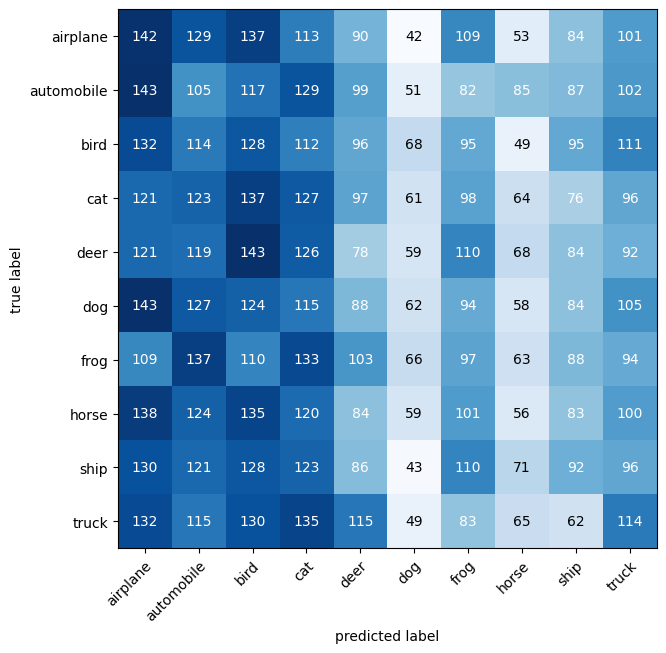

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Chuyển y_preds thành tensor
y_pred_tensor = torch.cat(y_preds)
# Chuyển test_data.targets thành tensor
targets_tensor = torch.tensor(test_data.targets)


cm = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
cm_tensor = cm(preds=y_pred_tensor, target=targets_tensor)

# Vẽ Confusion Matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# OpenCV

In [ ]:
import cv2
import numpy as np

In [ ]:
import os
print("Train dataset classes:", os.listdir("CIFAR-10-dataset/train"))
print("Airplane class images:", os.listdir("CIFAR-10-dataset/train/airplane"))

Train dataset classes: ['automobile', 'airplane', 'truck', 'ship', 'bird', 'horse', 'deer', 'frog', 'cat', 'dog']
Airplane class images: ['monoplane_s_000759.png', 'stealth_fighter_s_000029.png', 'fighter_aircraft_s_001003.png', 'attack_aircraft_s_000375.png', 'stealth_fighter_s_000174.png', 'stealth_fighter_s_000395.png', 'fighter_s_000752.png', 'attack_aircraft_s_001127.png', 'jumbo_jet_s_000185.png', 'kamikaze_s_000018.png', 'stealth_bomber_s_001660.png', 'twinjet_s_000886.png', 'twinjet_s_000850.png', 'attack_aircraft_s_000330.png', 'fighter_aircraft_s_001084.png', 'stealth_fighter_s_001685.png', 'dive_bomber_s_001694.png', 'jetliner_s_001877.png', 'biplane_s_001127.png', 'dive_bomber_s_001473.png', 'jumbo_jet_s_000862.png', 'biplane_s_000475.png', 'jumbo_jet_s_000026.png', 'dive_bomber_s_000395.png', 'monoplane_s_000999.png', 'jumbo_jet_s_000412.png', 'fighter_aircraft_s_001295.png', 'hangar_queen_s_000014.png', 'attack_aircraft_s_000577.png', 'jetliner_s_001595.png', 'stealth_bom

In [ ]:
# # Lấy ảnh từ OpenCV và infer
# def infer_image(model, image_path, transform, class_names, device=device):
#     model.eval()
#     image_path = 'CIFAR-10-dataset/test/cat/0007.png'
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi từ BGR sang RGB

#     plt.imshow(image)
#     plt.axis("off")
#     plt.title("Input Image")
#     plt.show()

#     # Tiền xử lý ảnh
#     image_tensor = transform(image).unsqueeze(0).to(device)

#     # Infer
#     with torch.inference_mode():
#         preds = model(image_tensor)
#         pred_class = preds.argmax(dim=1).item()

#     print(f"Predicted class: {class_names[pred_class]}")
#     return pred_class

# # Lấy 2 ảnh và infer
# from torchvision import transforms

# # Transform giống như khi train
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((32, 32)),  # CIFAR-10 dùng 32x32
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Sửa nếu bạn dùng chuẩn hóa khác
# ])

# image1_path = "CIFAR-10-dataset/train/airplane/0001.png"  # Đường dẫn ảnh 1
# image2_path = "CIFAR-10-dataset/test/cat/0007.png"  # Đường dẫn ảnh 2

# print("Inferencing Image 1:")
# infer_image(model, image1_path, transform, class_names)

# print("Inferencing Image 2:")
# infer_image(model, image2_path, transform, class_names)

Inferencing Image 1:


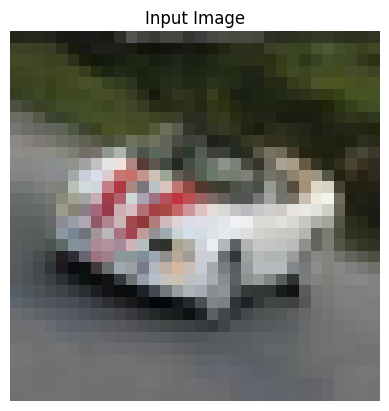

Predicted class: automobile
Inferencing Image 2:


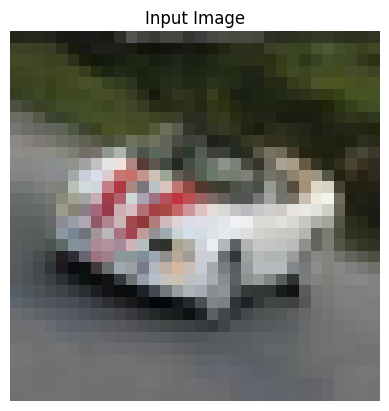

Predicted class: automobile


1

In [ ]:
import cv2
import numpy as np
from torchvision import transforms

# Transform về như trước khi train
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Chuẩn hóa
])

# Lấy ảnh từ OpenCV và infer
def infer_image(model, image_path, transform, class_names, device=device):
    model.eval()
    image_path = '/content/CIFAR-10-dataset/train/automobile/convertible_s_002809.png'
    image = cv2.imread(image_path)


    if image is None:
        raise ValueError(f"Không thể đọc hình ảnh từ đường dẫn: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi từ BGR sang RGB

    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # Tiền xử lý ảnh
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Infer
    with torch.inference_mode():
        preds = model(image_tensor)
        pred_class = preds.argmax(dim=1).item()

    print(f"Predicted class: {class_names[pred_class]}")
    return pred_class

# Lấy 2 ảnh và infer
image1_path = "/content/CIFAR-10-dataset/train/airplane/aeroplane_s_000004.png"
image2_path = "/content/CIFAR-10-dataset/test/cat/alley_cat_s_001424.png"

print("Inferencing Image 1:")
infer_image(model, image1_path, transform, class_names)

print("Inferencing Image 2:")
infer_image(model, image2_path, transform, class_names)